In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
import matplotlib
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from scipy.stats import pearsonr

In [2]:
#unhooking moments from manual annotations
unhooking_moments = [[27, 93, 162, 244],
 [34, 120, 207, 311, 390],
 [55, 164, 272],
 [61, 205, 328, 439],
 [68, 144, 211],
 [88, 176, 270, 385],
 [79, 202, 283],
 [233, 349, 486, 624, 762, 900],
 [39, 169, 277, 365],
 [101, 201, 299, 412],
 [102, 237, 320, 444],
 [88, 169, 260, 341]]

# Import skeleton data

In [3]:
skeleton_folder_path = "/home/yingtao/Desktop/DLC-100frs/lt-100frames-liu-2022-04-27/videos/filtered-skeleton/"

In [4]:
#csv files of filtered skeleton length generated by DLC, which are created from result of tracked points filtered by a median filter of window length 11
skeleton_paths = [
 '2(10)-780-1100(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '3(11)-1950-2450(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '4(12)-2050-2350(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '5(13)-400-1000(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '6(14)-350-700(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '8(0401-7)-2100-2650(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '2(10)-3200-3500DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '3(11-2)-250-1160DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '4(12)-780-1150DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '5(13)-1-600DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '6(14)-1350-1940DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv',
 '8(0401-7)-1250-1650DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered_skeleton.csv']

In [5]:
#all skeleton parts
c_labels = [
 'VL-a8p_VL-a87',
 'VL-a87_VL-a76',
 'VL-a76_VL-a65',
 'VL-a65_VL-a54',
 'VL-a54_VL-a43',
 'VL-a43_VL-a32',
 'VL-a32_VL-a21',
 'VL-a21_VL-a1t3',
 'VL-a1t3_VL-t32',
 'VL-t32_VL-t21',
 'VL-t21_VL-t1a',
 'DL-a8p_DL-a87',
 'DL-a87_DL-a76',
 'DL-a76_DL-a65',
 'DL-a65_DL-a54',
 'DL-a54_DL-a43',
 'DL-a43_DL-a32',
 'DL-a32_DL-a21',
 'DL-a21_DL-a1t3',
 'DL-a1t3_DL-t32',
 'DL-t32_DL-t21',
 'DL-t21_VL-t1a',
 'LT4-v_LT4-d',
 'LT3-v_LT3-d',
 'LT2-v_LT2-d',
 'LT1-v_LT1-d']

In [6]:
#import the data of one bodypart/skeleton as a numpy masked array, data with likelihood smaller than 0.8 or strange orientations for LT muscles will be masked as False 
def get_cutoff_csv(Dataframe, bodypart, pcutoff=0.8,kw = 'length',o_flag=False):
    prob = np.array([float(i) for i in Dataframe[bodypart+'.2'][1:]])
    orie = np.array([float(i) for i in Dataframe[bodypart+'.1'][1:]])
    mask1 = prob < pcutoff
    mask2 = abs(orie-90) > 20
    if bodypart[0:2] == 'LT':
        o_flag = True
    if o_flag == True:
        temp_length = np.ma.array([float(i) for i in Dataframe[bodypart][1:]], mask=mask1 | mask2, fill_value = 999999)
    else:
        temp_length = np.ma.array([float(i) for i in Dataframe[bodypart][1:]], mask=mask1, fill_value = 999999)
    return(temp_length)

In [7]:
#import the data of one csv file by the name of the bodypart/skeleton  
def get_csv_length(path,skeleton_names):
    Dataframe = pd.read_csv(path)
    length_dict = {}
    for i in skeleton_names:
        length_dict[i] = get_cutoff_csv(Dataframe,i)
    return(length_dict)

In [8]:
#median filter
def nan_median(arr,s=5):
    k = s//2
    arr_medianed = np.empty(arr.shape[0])
    for n,i in enumerate(arr):
        if n<k or n+k>arr_medianed.shape[0]:
            arr_medianed[n] = np.nan
        else:
            arr_medianed[n] = np.nanmedian(arr[n-k:n+k])
    return(arr_medianed)

In [9]:
#import the muscle lengths of each strides
lengths_strides = []
"""
lengths_strides: n * m * k lists of numpy arrays of the tracked muscle lengths
n: number of videos (n=12)
m: number of strides (m in [2,3,4,5] )
k: number of skeleton parts arranged as c_labels
numpy array: skeleton length during a stride with leading 10 frames and following 10 frames [unhooking moment(n) - 10, unhooking moment(n+1) + 10]
"""
for path,um in zip(skeleton_paths,unhooking_moments):
    length = get_csv_length(os.path.join(skeleton_folder_path, path), c_labels)
    length_stride = []
    #medianed filtered, windowlength=5
    for key in length:
        length[key] = nan_median(length[key],5)
    for u1,u2 in zip(um[:-1],um[1:]):
        s = []
        for l in c_labels:
            s.append(length[l][u1-1-10:u2-1+10])
        length_stride.append(s[:])
    lengths_strides.append(length_stride[:])

/home/yingtao/anaconda3/envs/caiman/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/yingtao/anaconda3/envs/caiman/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Warning: converting a masked element to nan.
  if __name__ == '__main__':


## Import keypoints coordinates

In [10]:
kp_folder_path = "/home/yingtao/Desktop/DLC-100frs/lt-100frames-liu-2022-04-27/videos/filtered-keypoints-median-9/"

In [11]:
#csv files of filtered skeleton length generated by DLC, which are created from result of tracked points filtered by a median filter of window length 11
kp_paths = [
 '2(10)-780-1100(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '3(11)-1950-2450(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '4(12)-2050-2350(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '5(13)-400-1000(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '6(14)-350-700(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '8(0401-7)-2100-2650(50)DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '2(10)-3200-3500DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '3(11-2)-250-1160DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '4(12)-780-1150DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '5(13)-1-600DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '6(14)-1350-1940DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv',
 '8(0401-7)-1250-1650DLC_resnet_50_lt-100framesApr27shuffle1_750000_filtered.csv']

In [12]:
#all skeleton parts
kp_labels = [
"VL-a8p",
"VL-a87",
"VL-a76",
"VL-a65",
"VL-a54",
"VL-a43",
"VL-a32",
"VL-a21",
"VL-a1t3",
"VL-t32",
"VL-t21",
"VL-t1a",
"DL-a8p",
"DL-a87",
"DL-a76",
"DL-a65",
"DL-a54",
"DL-a43",
"DL-a32",
"DL-a21",
"DL-a1t3",
"DL-t32",
"DL-t21",
"DL-t1a",
"LT4-v",
"LT4-d",
"LT3-v",
"LT3-d",
"LT2-v",
"LT2-d",
"LT1-v",
"LT1-d"]

In [13]:
#import the data of one bodypart/skeleton as a numpy masked array, data with likelihood smaller than 0.8 or strange orientations for LT muscles will be masked as False 
def get_cutoff_csv_kp(Dataframe, bodypart, pcutoff=0.8,kw = ['x','y'],o_flag=False):
    new_header = Dataframe.iloc[0] #grab the first row for the header
    Dataframe.columns = new_header #set the header row as the df header
    prob = np.array([float(i) for i in Dataframe[bodypart].iloc[2:,2]])
    mask1 = prob < pcutoff
    x = np.ma.array([float(i) for i in Dataframe[bodypart].iloc[2:,0]], mask=mask1, fill_value = 999999)
    y = np.ma.array([float(i) for i in Dataframe[bodypart].iloc[2:,1]], mask=mask1, fill_value = 999999)
    return([x,y])

In [14]:
#import the data of one csv file by the name of the bodypart/skeleton  
def get_kp(path,kp_names):
    Dataframe = pd.read_csv(path)
    length_dict = {}
    for i in kp_names:
        length_dict[i] = get_cutoff_csv_kp(Dataframe,i)
    return(length_dict)

In [15]:
#import the muscle lengths of each strides
kp_strides = []
"""
lengths_strides: n * m * k lists of numpy arrays of the tracked muscle lengths
n: number of videos (n=12)
m: number of strides (m in [2,3,4,5] )
k: number of skeleton parts arranged as c_labels
numpy array: skeleton length during a stride with leading 10 frames and following 10 frames [unhooking moment(n) - 10, unhooking moment(n+1) + 10]
"""
for path,um in zip(kp_paths,unhooking_moments):
    coords = get_kp(os.path.join(kp_folder_path, path), kp_labels)
    coords_stride = []
    #medianed filtered, windowlength=5
    for u1,u2 in zip(um[:-1],um[1:]):
        s = []
        for l in kp_labels:
            s.append([coords[l][n][u1-1-10:u2-1+10].filled(np.nan) for n in [0,1]])
        coords_stride.append(s[:])
    kp_strides.append(coords_stride[:])

# plot the length relationship

In [16]:
"""
bodylength: (2*x_t1-x_vla8-x_dla8)/2
bodylength_n: (2*x_t1-x_vla8-x_dla8)/(2*x_t1-x_vla8-x_dla8)_min

LTlength: (LT_a4+LT_a5+LT_a6)/3
LTlength_n: (LT_a4+LT_a5+LT_a6)/(LT_a4+LT_a5+LT_a6)_max

Calculate bending index:
dv_ratio: (DL_a8+DL_a7+..+DL_a4)/(VL_a8+VL_a7+..+VL_a4)
tail_diff: x_vla8 - x_dla8
da8_position: x_dla8, y_dla8
"""


'\nbodylength: (2*x_t1-x_vla8+x_dla8)/2\nbodylength_n: (2*x_t1-x_vla8+x_dla8)/(2*x_t1-x_vla8+x_dla8)_min\n\nLTlength: (LT_a4+LT_a5+LT_a6)/3\nLTlength_n: (LT_a4+LT_a5+LT_a6)/(LT_a4+LT_a5+LT_a6)_max\n\nCalculate bending index:\ndv_ratio: (DL_a8+DL_a7+..+DL_a4)/(VL_a8+VL_a7+..+VL_a4)\ntail_diff: x_vla8 - x_dla8\nda8_position: x_dla8, y_dla8\n'

In [17]:
bodylength = []
bodylength_n = []
da8_position = []
da8x_position_n = []
tail_diff = []
for video_n in kp_strides:
    dp_ = []
    td_ = []
    bl_ = []
    bln_ = [] 
    dxpn_ = []
    for stride in video_n:
        #0:VL_a8p, 12:DL_a8p,
        dp_.append(stride[12])
        td_.append(stride[0][0] - stride[12][0])
        #0:VL_a8p, 11:VL_t1a, 12:DL_a8p,
        bl_.append((2*stride[11][0] - stride[0][0] -stride[12][0])/2)
        bln_.append((2*stride[11][0] - stride[0][0] -stride[12][0])/np.nanmin(2*stride[11][0] - stride[0][0] -stride[12][0]))
        dxpn_.append(stride[12][0]-np.nanmin(stride[12][0]))
    da8_position.append(dp_[:])
    tail_diff.append(td_[:])
    bodylength.append(bl_[:])
    bodylength_n.append(bln_[:])
    da8x_position_n.append(dxpn_[:])

In [18]:
#dv_ratio: (DL_a8+DL_a7+..+DL_a4)/(VL_a8+VL_a7+..+VL_a4)
dv_ratio = []
LTlength = []
LTlength_n = []
for video_n in lengths_strides:
    dr_ = []
    ll_ = []
    lln_ = []
    for stride in video_n:
        #-1:LT_a4, -2:LT_a5, -3:LT_a6
        dr_.append(np.sum(stride[0:5],axis=0)/np.sum(stride[11:16],axis=0))
        #-1:LT_a4, -2:LT_a5, -3:LT_a6
        ll_.append((stride[-1] + stride[-2] + stride[-3])/3)
        lln_.append((stride[-1] + stride[-2] + stride[-3])/np.nanmax(stride[-1] + stride[-2] + stride[-3]))
    dv_ratio.append(dr_[:])
    LTlength.append(ll_[:])
    LTlength_n.append(lln_[:])

In [19]:
%matplotlib inline

In [20]:
font = {'family' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

Text(0, 0.5, 'body_length')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


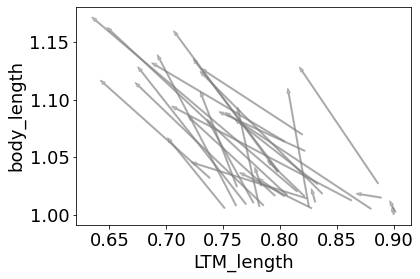

In [21]:
#body_length and LT_min
LT_min = []
bl_max = []
for i,j in zip(LTlength_n,bodylength_n):
    for k,l in zip(i,j):
        if np.count_nonzero(np.isnan(k)) < 20 and np.count_nonzero(np.isnan(l)) < 20:
            LT_min.append(np.nanmin(k))
            bl_max.append(np.nanmax(l))
            if np.isnan(l[10]) or np.isnan(k[10]):
                continue
            else:
                #plt.plot([l[0],l[np.nanargmin(k)]],[k[0],k[np.nanargmin(k)]],marker="o")
                plt.arrow(k[10],l[10],k[np.nanargmin(k)]-k[10],l[np.nanargmin(k)]-l[10],alpha=0.5,color='grey')
plt.xlabel('LTM_length')
plt.ylabel('body_length')

Text(0, 0.5, 'max_body_length')

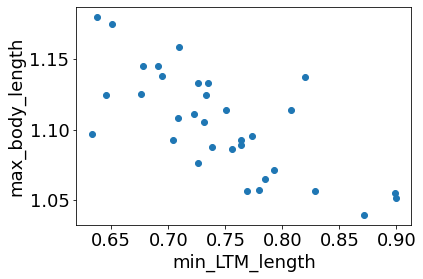

In [22]:
plt.scatter(LT_min,bl_max)
plt.xlabel('min_LTM_length')
plt.ylabel('max_body_length')

In [23]:
pearsonr(LT_min,bl_max)

(-0.7164734868758565, 2.7409616525668746e-06)